## Load Everything

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import math
import gc
import copy

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('..')
from lib.line_notif import send_message
from lib.utils import reduce_mem_usage, current_time, unpickle, to_pickle
#from lightgbm import LGBMRegressor

In [103]:

#カラム内の文字数。デフォルトは50
pd.set_option("display.max_colwidth", 100)

#行数
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
#

In [2]:
DATA_PATH = '../input'
SUBMISSIONS_PATH = './'
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

## Load Dataset

By default all data is read as `float64` and `int64`. We can trade this uneeded precision for memory and higher prediction speed. So, let's read with Pandas all the data in the minimal representation: 

In [4]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train_csv = pd.read_csv(f'{DATA_PATH}/train.csv', index_col='id', dtype=train_dtypes)
train_csv['molecule_index'] = train_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train_csv = train_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
train_csv.head(10)

/home/kenichi.matsui/anaconda3/envs/kaggle_3.6/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,1,1,0,1JHC,84.807602
1,1,1,2,2JHH,-11.257000
2,1,1,3,2JHH,-11.254800
3,1,1,4,2JHH,-11.254300
4,1,2,0,1JHC,84.807404
5,1,2,3,2JHH,-11.254100
6,1,2,4,2JHH,-11.254800
7,1,3,0,1JHC,84.809303
8,1,3,4,2JHH,-11.254300


In [5]:
print('Shape: ', train_csv.shape)
print('Total: ', train_csv.memory_usage().sum())
train_csv.memory_usage()

Shape:  (4658147, 5)
Total:  88505177


Index                       37265176
molecule_index              18632588
atom_index_0                4658147 
atom_index_1                4658147 
type                        4658531 
scalar_coupling_constant    18632588
dtype: int64

In [6]:
submission_csv = pd.read_csv(f'{DATA_PATH}/sample_submission.csv', index_col='id')

In [7]:
test_csv = pd.read_csv(f'{DATA_PATH}/test.csv', index_col='id', dtype=train_dtypes)
test_csv['molecule_index'] = test_csv['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test_csv = test_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]
test_csv.head(10)

,molecule_index,atom_index_0,atom_index_1,type
id,,,,
4658147,4,2,0,2JHC
4658148,4,2,1,1JHC
4658149,4,2,3,3JHH
4658150,4,3,0,1JHC
4658151,4,3,1,2JHC
4658152,15,3,0,1JHC
4658153,15,3,2,3JHC
4658154,15,3,4,2JHH
4658155,15,3,5,2JHH


In [8]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_csv = pd.read_csv(f'{DATA_PATH}/structures.csv', dtype=structures_dtypes)
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')
structures_csv.head(10)

,molecule_index,atom_index,atom,x,y,z
0,1,0,6,-0.012698,1.085804,0.008001
1,1,1,1,0.002150,-0.006031,0.001976
2,1,2,1,1.011731,1.463751,0.000277
3,1,3,1,-0.540815,1.447527,-0.876644
4,1,4,1,-0.523814,1.437933,0.906397
5,2,0,7,-0.040426,1.024108,0.062564
6,2,1,1,0.017257,0.012545,-0.027377
7,2,2,1,0.915789,1.358745,-0.028758
8,2,3,1,-0.520278,1.343532,-0.775543
9,3,0,8,-0.034360,0.977540,0.007602


In [9]:
print('Shape: ', structures_csv.shape)
print('Total: ', structures_csv.memory_usage().sum())
structures_csv.memory_usage()

Shape:  (2358657, 6)
Total:  42455954


Index             128    
molecule_index    9434628
atom_index        2358657
atom              2358657
x                 9434628
y                 9434628
z                 9434628
dtype: int64

## Build Distance Dataset

In [10]:
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    return base, structures

In [11]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [12]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

In [13]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [14]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))

def add_distance_to_center(df):
    df['d_c'] = ((
        (df['x_c'] - df['x'])**np.float32(2) +
        (df['y_c'] - df['y'])**np.float32(2) + 
        (df['z_c'] - df['z'])**np.float32(2)
    )**np.float32(0.5))

def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [15]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [16]:
def add_n_atoms(base, structures):
    dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

In [17]:
def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

In [43]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = ['id', 'molecule_index', 'atom_index_0', 'atom_index_1',]
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    return df[labels]

def build_x_y_data(some_csv, coupling_type, n_atoms):
    full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=n_atoms)
    print(f"full.columns:{full.columns}")
    df = take_n_atoms(full, n_atoms)
    df = df.fillna(0)
    print(df.columns)
    
    if 'scalar_coupling_constant' in df:
        X_data = df.drop(['scalar_coupling_constant'], axis=1)#.values.astype('float32')
        y_data = df['scalar_coupling_constant']#.values.astype('float32')
    else:
        X_data = df#.values.astype('float32')
        y_data = None
    
    return X_data, y_data

def create_dataset(coupling_type, n_atoms, ):
    print(f'*** Training Model for {coupling_type} ***')
    
    X_data, y_data = build_x_y_data(train_csv, coupling_type, n_atoms)
    X_test, _ = build_x_y_data(test_csv, coupling_type, n_atoms)
    return X_data, y_data, X_test

In [44]:
model_params = {
    '1JHN': 7,
    '1JHC': 10,
    '2JHH': 9,
    '2JHN': 9,
    '2JHC': 9,
    '3JHH': 9,
    '3JHC': 10,
    '3JHN': 10
}

datasets = {}
for coupling_type in model_params.keys():
    X_data, y_data, X_test = create_dataset(coupling_type, n_atoms=model_params[coupling_type])
    datasets[coupling_type] = [X_data, y_data, X_test]
    
x_train_list, y_train_list, x_test_list = [], [], []
for k in datasets.keys():
    x_train_list += [datasets[k][0]]
    x_test_list  += [datasets[k][2]]
    
X_train = pd.concat(x_train_list, axis=0)
X_test = pd.concat(x_test_list, axis=0)

X_train.sort_values("id", inplace=True)
X_test.sort_values("id", inplace=True)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

*** Training Model for 1JHN ***
full.columns:Index(['id', 'molecule_index', 'atom_index_0', 'atom_index_1',
       'scalar_coupling_constant', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1',
       'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'x_2', 'x_3', 'x_4',
       'x_5', 'x_6', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'z_2', 'z_3', 'z_4',
       'z_5', 'z_6', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2',
       'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3',
       'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3'],
      dtype='object')
Index(['id', 'molecule_index', 'atom_index_0', 'atom_index_1', 'atom_2',
       'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0', 'd_2_1',
       'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0',
       'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'scalar_coupling_constant'],
      dtype='object')
full.columns:Index(['id', 'molecule_index', 'atom_index_0', 'atom_index_1', 'x_0', 'y_

full.columns:Index(['id', 'molecule_index', 'atom_index_0', 'atom_index_1',
       'scalar_coupling_constant', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1',
       'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'y_2', 'y_3', 'y_4',
       'y_5', 'y_6', 'y_7', 'y_8', 'z_2', 'z_3', 'z_4', 'z_5', 'z_6', 'z_7',
       'z_8', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0',
       'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0',
       'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0',
       'd_8_1', 'd_8_2', 'd_8_3'],
      dtype='object')
Index(['id', 'molecule_index', 'atom_index_0', 'atom_index_1', 'atom_2',
       'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'd_1_0',
       'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2',
       'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2',
       'd_6_3', '

In [81]:
X_train.drop(['id', 'molecule_index', 'atom_index_0', 'atom_index_1', ], axis=1).head()

,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3
0,1,1,1,0,0,0.0,0.0,0.0,1.091953,1.783120,1.091952,1.783147,1.091946,1.783158,1.783157,1.091948,1.783148,1.783148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,1,1,0,0,0.0,0.0,NaN,1.783120,1.091953,1.091952,1.783157,1.783148,1.091948,1.783147,1.783158,1.091946,1.783148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,6,1,1,0,0,0.0,0.0,NaN,1.783147,1.091953,1.091946,1.783120,1.783158,1.091952,1.783157,1.783148,1.091948,1.783148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,6,1,1,0,0,0.0,0.0,NaN,1.783157,1.091953,1.091948,1.783120,1.783148,1.091952,1.783147,1.783148,1.091946,1.783158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,1,1,1,0,0,0.0,0.0,0.0,1.091952,1.783120,1.091953,1.783148,1.091948,1.783157,1.783158,1.091946,1.783147,1.783148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
X_test.drop(['id', 'molecule_index', 'atom_index_0', 'atom_index_1', ], axis=1).head()

,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3
0,6,1,0,0,0,0.0,0.0,NaN,2.261178,1.062099,1.199079,3.323277,1.062099,2.261178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,6,1,0,0,0,0.0,0.0,0.0,1.062099,2.261178,1.199079,3.323277,2.261178,1.062099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,6,0,0,0,0.0,0.0,NaN,3.323277,2.261178,1.062099,1.062099,2.261178,1.199079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,6,1,0,0,0,0.0,0.0,0.0,1.062099,2.261178,1.199079,3.323277,2.261178,1.062099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,1,0,0,0,0.0,0.0,NaN,2.261178,1.062099,1.199079,3.323277,1.062099,2.261178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [83]:
to_pickle("../processed/v003/train_dist_all_you_need_feat.pkl", 
          X_train.drop(['id', 'molecule_index', 'atom_index_0', 'atom_index_1', ], axis=1))
to_pickle("../processed/v003/test_dist_all_you_need_feat.pkl", 
          X_test.drop(['id', 'molecule_index', 'atom_index_0', 'atom_index_1', ], axis=1))

In [144]:
X_train.columns

Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'atom_index_0', 'atom_index_1', 'd_1_0', 'd_2_0', 'd_2_1',
       'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0',
       'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0',
       'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0',
       'd_9_1', 'd_9_2', 'd_9_3', 'id', 'molecule_index'],
      dtype='object')

In [85]:
train_all.shape, train_csv.shape, X_train.shape

((4658147, 151), (4658147, 5), (4658147, 42))

In [84]:
test_csv.shape, X_test.shape

((2505542, 4), (2505542, 42))

In [96]:
train_csv.head()

,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,1,1,0,1JHC,84.807602
1,1,1,2,2JHH,-11.257000
2,1,1,3,2JHH,-11.254800
3,1,1,4,2JHH,-11.254300
4,1,2,0,1JHC,84.807404


In [109]:
train_all = unpickle("../processed/v003/v003_078/train_compact_v003_078_yiemon_123J_HnJ_H123J.pkl")
test_all = unpickle("../processed/v003/v003_078/test_compact_v003_078_yiemon_123J_HnJ_H123J.pkl")

train_ = pd.read_csv("../input/train.csv")
train_all["atom_index_0"] = train_["atom_index_0"].values
train_all["atom_index_1"] = train_["atom_index_1"].values
del train_
gc.collect()

In [110]:
train_all.head()

,1J1st_AveSmallestBondAngle_diff,1J1st_AverageBondAngle,1J1st_IsAxial,1J1st_IsPolarHydrogen,1J1st_MemberOfRingCount,1J1st_MemberOfRingSize,1J1st_SmallestBondAngle,1J_ex1_Angle_0_1_max,1J_ex1_Angle_0_1_mean,1J_ex1_Angle_0_1_min,1J_ex1_Angle_0_1_std,1J_ex1_AverageBondAngle_max,1J_ex1_SmallestBondAngle_max,1J_ex1_angle_fromEx1_max,1J_ex1_angle_fromEx1_max_min_diff,1J_ex1_angle_fromEx1_mean,1J_ex1_angle_fromEx1_min,1J_ex1_angle_fromEx1_std,1J_ex1_cos2T_F_L_EX1_mean,1J_ex1_cos2T_F_L_EX1_std,1J_ex1_dist_0_max_min_diff,1J_ex1_dist_0_mean,1J_ex1_dist_0_min,1J_ex1_dist_0_std,1J_ex1_dist_1_max_min_diff,1J_ex1_dist_1_mean,1J_ex1_dist_1_min,1J_ex1_dist_1_std,1J_ex1_dist_from_first_max,1J_ex1_dist_from_first_max_min_diff,1J_ex1_dist_from_first_mean,1J_ex1_dist_from_first_min,1J_ex1_dist_from_first_std,1Jlast_GetHeteroValence,1Jlast_GetPartialCharge,2J2nd_AverageBondAngle,2J2nd_MemberOfRingSize,2J2nd_SmallestBondAngle,2JExplicitHydrogenCount,2JGetHeteroValence,2JGetPartialCharge,2JHasAlphaBetaUnsat,2Jangle_from2nd_max,2Jangle_from2nd_mean,2Jangle_from2nd_min,2Jd_idx0_2nd,2Jd_idx1_2nd,2Jdist_from2nd_min,2Jdist_from2nd_var,3J2nd_MemberOfRingSize,3J2nd_SmallestBondAngle,3J3rd_AverageBondAngle,3J3rd_MemberOfRingSize,3J3rd_SmallestBondAngle,3JExplicitHydrogenCount,3JGetPartialCharge,3Jangle_from2nd_max,3Jangle_from2nd_mean,3Jd_idx1_2nd,3Jdist_from2nd_mean,3Jdist_from2nd_var,3Jlast_AverageBondAngle,3Jlast_SmallestBondAngle,Angle,a0_nb_inring5,a1_degree,a1_hybridization,a1_inring3,a1_inring4,a1_nb_o,cos2T,cosT,d_O_from1st_0,d_O_from1st_ratio_0,dist,dist_C_0_x,dist_C_0_y,dist_C_1_x,dist_C_1_y,dist_C_2_x,dist_C_2_y,dist_C_3_x,dist_C_3_y,dist_C_4_x,dist_C_4_y,dist_H_0_x,dist_H_0_y,dist_H_1_x,dist_H_1_y,dist_H_2_x,dist_H_2_y,dist_H_3_y,dist_H_4_y,dist_N_0_x,dist_N_0_y,dist_O_0_x,dist_O_0_y,dist_O_1_x,dist_O_1_y,dist_to_type_mean,eem2015ba_1,eem2015bm_0,eem2015bm_1,eem2015bn_1,eem2015ha_1,eem2015hm_1,eem_0,eem_1,f006:dist_from_origin_1,gasteiger_0,gasteiger_1,interBond_EquibLength,interBond_Length,mean_angle_C_from2nd,mean_angle_O_from2nd,mean_dist_C_from1st,mean_dist_C_from2nd,mean_dist_ratio_C_from2nd,mean_dist_ratio_O_from1st,mmff94_0,mmff94_1,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std_diff,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std_diff,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std_diff,molecule_type_0_dist_std_diff,molecule_type_dist_max,molecule_type_dist_min,molecule_type_dist_std_diff,pca_exp_3,qeq_1,qtpie_1,sum_circle_size,tda_max_radius,type,scalar_coupling_constant,fc,molecule_name,atom_index_0,atom_index_1
0,0.002812,109.471221,0.0,0.0,0.0,0.0,109.468408,109.472067,109.470598,109.468408,0.001578,0.0,360.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.000037,1.783141,1.78312,0.000016,0.000005,1.091949,1.091946,0.000002,1.091953,0.0,1.091953,1.091953,0.0,0.0,-0.077596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,4,4,0,0,0,NaN,NaN,NaN,NaN,1.091953,0.838672,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.314513,0.838682,0.314503,0.838680,0.3145,0.838674,0.838672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999134,-0.067349,0.201583,-0.806339,-0.851258,0.014606,-0.813021,0.161131,-0.644531,0.000004,0.019399,-0.077596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,-0.000007,0.999994,-1.091950,1.783157,0.691204,1.632998,1.474738,1.091953,0.000000,1.000000,-0.746359,1.091953,1.000000,1.091946,-0.000007,0.999994,-1.091950,-1.091950,1.091953,1.091946,-1.091950,0.397438,3.251140,-3.093807,0,NaN,0,84.8076,83.0224,dsgdb9nsd_000001,1,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.472067,109.470598,109.468408,0.001578,0.0,

In [98]:
def map_acsf(df, acsf_df, atom_idx):
    df = pd.merge(df, acsf_df, how='left',
                  left_on=['molecule_name', f'atom_index_{atom_idx}'],
                  right_on=['molecule_name', 'atom_index'])

    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={c:f"{c}_{atom_idx}" for c in acsf_df.columns[2:]})
    return df

In [133]:
ls -ltr ../processed/v003/acsf_feat.pkl

-rw-rw-r-- 1 kenichi.matsui kenichi.matsui 806138787 Aug  8 12:41 ../processed/v003/acsf_feat.pkl


In [134]:
acsf_df = unpickle("../processed/v003/acsf_feat.pkl")
# structures = pd.read_csv("../input/structures.csv")
# acsf_df["atom_index"] = structures["atom_index"]
# del acsf_df["atom"]

In [137]:
train_dummy  = map_acsf(train_all, acsf_df, 0)
train_dummy.shape, train_all.shape

((4658147, 233), (4658147, 153))

In [135]:
acsf_df.head(30)

,molecule_name,atom_index,acsf_0,acsf_1,acsf_2,acsf_3,acsf_4,acsf_5,acsf_6,acsf_7,acsf_8,acsf_9,acsf_10,acsf_11,acsf_12,acsf_13,acsf_14,acsf_15,acsf_16,acsf_17,acsf_18,acsf_19,acsf_20,acsf_21,acsf_22,acsf_23,acsf_24,acsf_25,acsf_26,acsf_27,acsf_28,acsf_29,acsf_30,acsf_31,acsf_32,acsf_33,acsf_34,acsf_35,acsf_36,acsf_37,acsf_38,acsf_39,acsf_40,acsf_41,acsf_42,acsf_43,acsf_44,acsf_45,acsf_46,acsf_47,acsf_48,acsf_49,acsf_50,acsf_51,acsf_52,acsf_53,acsf_54,acsf_55,acsf_56,acsf_57,acsf_58,acsf_59,acsf_60,acsf_61,acsf_62,acsf_63,acsf_64,acsf_65,acsf_66,acsf_67,acsf_68,acsf_69,acsf_70,acsf_71,acsf_72,acsf_73,acsf_74,acsf_75,acsf_76,acsf_77,acsf_78,acsf_79
0,dsgdb9nsd_000001,0,3.681918,3.650919,1.614263,0.096596,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.035712e-02,3.452372e-03,2.071424e-02,1.380949e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,dsgdb9nsd_000001,1,2.392355,1.295593,2.282453,0.544185,0.920479,0.912729,0.403568,0.024149,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.643117e-04,1.232333e-04,5.477140e-05,1.369300e-05,1.411043e-02,1.281576e-02,1.425463e-03,1.307903e-04,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,dsgdb9nsd_000001,2,2.392355,1.295591,2.282453,0.544185,0.920479,0.912729,0.403567,0.024149,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.643113e-04,1.232331e-04,5.477114e-05,1.369292e-05,1.411043e-02,1.281576e-02,1.425459e-03,1.307897e-04,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,dsgdb9nsd_000001,3,2.392349,1.295569,2.282457,0.544196,0.920480,0.912731,0.403563,0.024149,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.643068e-04,1.232305e-04,5.476816e-05,1.369190e-05,1.411009e-02,1.281548e-02,1.425390e-03,1.307804e-04,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dsgdb9nsd_000001,4,2.392349,1.295570,2.282457,0.544196,0.920480,0.912730,0.403564,0.024149,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.643068e-04,1.232305e-04,5.476816e-05,1.369190e-05,1.411007e-02,1.281546e-02,1.425388e-03,1.307803e-04,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,dsgdb9nsd_000002,0,2.792233,2.791408,1.062831,0.054767,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.456830e-02,5.345894e-03,2.513233e-02,1.590992e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00

In [130]:
acsf_df[acsf_df.molecule_name=="dsgdb9nsd_118220"].shape, structures[structures.molecule_name=="dsgdb9nsd_118220"].shape

((29, 82), (29, 6))

In [129]:
structures[structures.molecule_name=="dsgdb9nsd_118220"]

,molecule_name,atom_index,atom,x,y,z
2104074,dsgdb9nsd_118220,0,C,-0.063981,1.670386,-0.110404
2104075,dsgdb9nsd_118220,1,C,0.021143,0.159066,0.124959
2104076,dsgdb9nsd_118220,2,C,-1.351508,-0.523936,0.088857
2104077,dsgdb9nsd_118220,3,C,-1.332203,-2.060131,0.220074
2104078,dsgdb9nsd_118220,4,C,-0.830488,-2.510521,1.600084
2104079,dsgdb9nsd_118220,5,C,-2.734126,-2.620971,-0.094081
2104080,dsgdb9nsd_118220,6,C,-2.895902,-4.153304,-0.124275
2104081,dsgdb9nsd_118220,7,C,-4.368113,-4.520213,-0.360986
2104082,dsgdb9nsd_118220,8,C,-2.000908,-4.817615,-1.180154
2104083,dsgdb9nsd_118220,9,H,0.926008,2.136609,-0.082430


In [136]:
acsf_df[acsf_df.molecule_name=="dsgdb9nsd_118220"]

,molecule_name,atom_index,acsf_0,acsf_1,acsf_2,acsf_3,acsf_4,acsf_5,acsf_6,acsf_7,acsf_8,acsf_9,acsf_10,acsf_11,acsf_12,acsf_13,acsf_14,acsf_15,acsf_16,acsf_17,acsf_18,acsf_19,acsf_20,acsf_21,acsf_22,acsf_23,acsf_24,acsf_25,acsf_26,acsf_27,acsf_28,acsf_29,acsf_30,acsf_31,acsf_32,acsf_33,acsf_34,acsf_35,acsf_36,acsf_37,acsf_38,acsf_39,acsf_40,acsf_41,acsf_42,acsf_43,acsf_44,acsf_45,acsf_46,acsf_47,acsf_48,acsf_49,acsf_50,acsf_51,acsf_52,acsf_53,acsf_54,acsf_55,acsf_56,acsf_57,acsf_58,acsf_59,acsf_60,acsf_61,acsf_62,acsf_63,acsf_64,acsf_65,acsf_66,acsf_67,acsf_68,acsf_69,acsf_70,acsf_71,acsf_72,acsf_73,acsf_74,acsf_75,acsf_76,acsf_77,acsf_78,acsf_79
0,dsgdb9nsd_118220,0,5.932207,3.158391,3.239091,1.936584,1.916001,0.694201,1.141102,0.718856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.659741e-03,1.976343e-03,1.055692e-02,6.873519e-03,0.000829,0.000617,0.000592,0.000380,0.000011,0.000010,0.000001,8.418131e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,dsgdb9nsd_118220,1,7.591013,2.765938,4.880827,3.322044,3.080398,1.326800,1.906839,1.271023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.061080e-03,7.508627e-04,3.618346e-03,2.308128e-03,0.001732,0.001388,0.000877,0.000533,0.000012,0.000009,0.000009,5.801121e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,dsgdb9nsd_118220,2,8.679097,2.526930,4.809030,4.930280,4.017595,1.441410,2.761058,1.823752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.048557e-03,7.482637e-04,3.567406e-03,2.267113e-03,0.001244,0.000927,0.000835,0.000518,0.000036,0.000032,0.000010,4.789991e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,dsgdb9nsd_118220,3,9.596390,2.239019,6.306166,5.149791,4.715662,1.987980,3.001559,1.992520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.025656e-05,1.397084e-05,1.180712e-05,5.521402e-06,0.002148,0.001828,0.000721,0.000401,0.000026,0.000017,0.000026,1.702797e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dsgdb9nsd_118220,4,7.889583,3.014826,3.245332,3.823608,3.568885,0.755713,1.844898,2.182667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.733810e-03,2.006406e-03,1.065530e-02,6.927897e-03,0.000544,0.000355,0.000557,0.000368,0.000021,0.000019,0.000002,1.722113e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,dsgdb9nsd_118220,5,9.312423,2.386845,4.743860,5.934201,4.500312,1.495651,3.237566,2.318218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.035119e-03,7.416467e-04,3.551868e-03,2.258395e-03,0.000960,0.000659,0.000811,0.000511,0.000048,0.000042,0.000010,4.161393e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,dsgdb9nsd_118220,6,8.723516,2.361754,6.462064,4.417382,3.898061,1.948285,2.575381,1.375704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.600613e-05,1.805221e-05,1.465675e-05,6.702828e-06,0.002377,0.002042,0.000745,0.000410,0.000019,0.000010,0.000027,1.786325e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,dsgdb9nsd_118220,7,6.762906,3.043163,3.277305,2.916742,2.563231,0.759190,1.640078,1.212795,0.0,0.0,0.0,0.0,0.0,0.0,

In [122]:
aa = acsf_df[["molecule_name", "atom_index"]].copy()
aa["cnt"] = 1
aa_size = aa.groupby(["molecule_name", "atom_index"]).size()

In [126]:
aa_size.sort_values(ascending=False).head()

molecule_name     atom_index
dsgdb9nsd_118220  0             7
dsgdb9nsd_100100  1             7
dsgdb9nsd_102405  1             7
                  0             7
dsgdb9nsd_117655  1             7
dtype: int64

In [117]:
acsf_df.shape, acsf_df[["molecule_name", "atom_index"]].drop_duplicates().shape

((2358657, 82), (657083, 2))

((4662156, 233), (4658147, 153))

In [113]:
train_all.head(30)

,1J1st_AveSmallestBondAngle_diff,1J1st_AverageBondAngle,1J1st_IsAxial,1J1st_IsPolarHydrogen,1J1st_MemberOfRingCount,1J1st_MemberOfRingSize,1J1st_SmallestBondAngle,1J_ex1_Angle_0_1_max,1J_ex1_Angle_0_1_mean,1J_ex1_Angle_0_1_min,1J_ex1_Angle_0_1_std,1J_ex1_AverageBondAngle_max,1J_ex1_SmallestBondAngle_max,1J_ex1_angle_fromEx1_max,1J_ex1_angle_fromEx1_max_min_diff,1J_ex1_angle_fromEx1_mean,1J_ex1_angle_fromEx1_min,1J_ex1_angle_fromEx1_std,1J_ex1_cos2T_F_L_EX1_mean,1J_ex1_cos2T_F_L_EX1_std,1J_ex1_dist_0_max_min_diff,1J_ex1_dist_0_mean,1J_ex1_dist_0_min,1J_ex1_dist_0_std,1J_ex1_dist_1_max_min_diff,1J_ex1_dist_1_mean,1J_ex1_dist_1_min,1J_ex1_dist_1_std,1J_ex1_dist_from_first_max,1J_ex1_dist_from_first_max_min_diff,1J_ex1_dist_from_first_mean,1J_ex1_dist_from_first_min,1J_ex1_dist_from_first_std,1Jlast_GetHeteroValence,1Jlast_GetPartialCharge,2J2nd_AverageBondAngle,2J2nd_MemberOfRingSize,2J2nd_SmallestBondAngle,2JExplicitHydrogenCount,2JGetHeteroValence,2JGetPartialCharge,2JHasAlphaBetaUnsat,2Jangle_from2nd_max,2Jangle_from2nd_mean,2Jangle_from2nd_min,2Jd_idx0_2nd,2Jd_idx1_2nd,2Jdist_from2nd_min,2Jdist_from2nd_var,3J2nd_MemberOfRingSize,3J2nd_SmallestBondAngle,3J3rd_AverageBondAngle,3J3rd_MemberOfRingSize,3J3rd_SmallestBondAngle,3JExplicitHydrogenCount,3JGetPartialCharge,3Jangle_from2nd_max,3Jangle_from2nd_mean,3Jd_idx1_2nd,3Jdist_from2nd_mean,3Jdist_from2nd_var,3Jlast_AverageBondAngle,3Jlast_SmallestBondAngle,Angle,a0_nb_inring5,a1_degree,a1_hybridization,a1_inring3,a1_inring4,a1_nb_o,cos2T,cosT,d_O_from1st_0,d_O_from1st_ratio_0,dist,dist_C_0_x,dist_C_0_y,dist_C_1_x,dist_C_1_y,dist_C_2_x,dist_C_2_y,dist_C_3_x,dist_C_3_y,dist_C_4_x,dist_C_4_y,dist_H_0_x,dist_H_0_y,dist_H_1_x,dist_H_1_y,dist_H_2_x,dist_H_2_y,dist_H_3_y,dist_H_4_y,dist_N_0_x,dist_N_0_y,dist_O_0_x,dist_O_0_y,dist_O_1_x,dist_O_1_y,dist_to_type_mean,eem2015ba_1,eem2015bm_0,eem2015bm_1,eem2015bn_1,eem2015ha_1,eem2015hm_1,eem_0,eem_1,f006:dist_from_origin_1,gasteiger_0,gasteiger_1,interBond_EquibLength,interBond_Length,mean_angle_C_from2nd,mean_angle_O_from2nd,mean_dist_C_from1st,mean_dist_C_from2nd,mean_dist_ratio_C_from2nd,mean_dist_ratio_O_from1st,mmff94_0,mmff94_1,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std_diff,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std_diff,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std_diff,molecule_type_0_dist_std_diff,molecule_type_dist_max,molecule_type_dist_min,molecule_type_dist_std_diff,pca_exp_3,qeq_1,qtpie_1,sum_circle_size,tda_max_radius,type,scalar_coupling_constant,fc,molecule_name,atom_index_0,atom_index_1
0,0.002812,109.471221,0.0,0.0,0.0,0.0,109.468408,109.472067,109.470598,109.468408,0.001578,0.000000,360.000000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000037,1.783141,1.783120,0.000016,0.000005,1.091949,1.091946,0.000002,1.091953,0.000000,1.091953,1.091953,0.000000,0.0,-0.077596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,4,4,0,0,0,NaN,NaN,NaN,NaN,1.091953,0.838672,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.314513,0.838682,0.314503,0.838680,0.314500,0.838674,0.838672,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.999134,-0.067349,0.201583,-0.806339,-0.851258,0.014606,-0.813021,0.161131,-0.644531,0.000004,0.019399,-0.077596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.0000,-6.680479e-06,0.999994,-1.091950,1.783157,0.691204,1.632998,1.474738,1.091953,0.000000,1.000000,-0.746359,1.091953,1.000000,1.091946,-6.680479e-06,0.999994,-1.091950,-1.091950,1.091953,1.091946,-1.091950,3.974383e-01,3.251140,-3.093807,0,NaN,0,84.80760,83.02240,dsgdb9nsd_

In [114]:
train_dummy.head(30)

,1J1st_AveSmallestBondAngle_diff,1J1st_AverageBondAngle,1J1st_IsAxial,1J1st_IsPolarHydrogen,1J1st_MemberOfRingCount,1J1st_MemberOfRingSize,1J1st_SmallestBondAngle,1J_ex1_Angle_0_1_max,1J_ex1_Angle_0_1_mean,1J_ex1_Angle_0_1_min,1J_ex1_Angle_0_1_std,1J_ex1_AverageBondAngle_max,1J_ex1_SmallestBondAngle_max,1J_ex1_angle_fromEx1_max,1J_ex1_angle_fromEx1_max_min_diff,1J_ex1_angle_fromEx1_mean,1J_ex1_angle_fromEx1_min,1J_ex1_angle_fromEx1_std,1J_ex1_cos2T_F_L_EX1_mean,1J_ex1_cos2T_F_L_EX1_std,1J_ex1_dist_0_max_min_diff,1J_ex1_dist_0_mean,1J_ex1_dist_0_min,1J_ex1_dist_0_std,1J_ex1_dist_1_max_min_diff,1J_ex1_dist_1_mean,1J_ex1_dist_1_min,1J_ex1_dist_1_std,1J_ex1_dist_from_first_max,1J_ex1_dist_from_first_max_min_diff,1J_ex1_dist_from_first_mean,1J_ex1_dist_from_first_min,1J_ex1_dist_from_first_std,1Jlast_GetHeteroValence,1Jlast_GetPartialCharge,2J2nd_AverageBondAngle,2J2nd_MemberOfRingSize,2J2nd_SmallestBondAngle,2JExplicitHydrogenCount,2JGetHeteroValence,2JGetPartialCharge,2JHasAlphaBetaUnsat,2Jangle_from2nd_max,2Jangle_from2nd_mean,2Jangle_from2nd_min,2Jd_idx0_2nd,2Jd_idx1_2nd,2Jdist_from2nd_min,2Jdist_from2nd_var,3J2nd_MemberOfRingSize,3J2nd_SmallestBondAngle,3J3rd_AverageBondAngle,3J3rd_MemberOfRingSize,3J3rd_SmallestBondAngle,3JExplicitHydrogenCount,3JGetPartialCharge,3Jangle_from2nd_max,3Jangle_from2nd_mean,3Jd_idx1_2nd,3Jdist_from2nd_mean,3Jdist_from2nd_var,3Jlast_AverageBondAngle,3Jlast_SmallestBondAngle,Angle,a0_nb_inring5,a1_degree,a1_hybridization,a1_inring3,a1_inring4,a1_nb_o,cos2T,cosT,d_O_from1st_0,d_O_from1st_ratio_0,dist,dist_C_0_x,dist_C_0_y,dist_C_1_x,dist_C_1_y,dist_C_2_x,dist_C_2_y,dist_C_3_x,dist_C_3_y,dist_C_4_x,dist_C_4_y,dist_H_0_x,dist_H_0_y,dist_H_1_x,dist_H_1_y,dist_H_2_x,dist_H_2_y,dist_H_3_y,dist_H_4_y,dist_N_0_x,dist_N_0_y,dist_O_0_x,dist_O_0_y,dist_O_1_x,dist_O_1_y,dist_to_type_mean,eem2015ba_1,eem2015bm_0,eem2015bm_1,eem2015bn_1,eem2015ha_1,eem2015hm_1,eem_0,eem_1,f006:dist_from_origin_1,gasteiger_0,gasteiger_1,interBond_EquibLength,interBond_Length,mean_angle_C_from2nd,mean_angle_O_from2nd,mean_dist_C_from1st,mean_dist_C_from2nd,mean_dist_ratio_C_from2nd,mean_dist_ratio_O_from1st,mmff94_0,mmff94_1,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std_diff,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std_diff,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std_diff,molecule_type_0_dist_std_diff,molecule_type_dist_max,molecule_type_dist_min,molecule_type_dist_std_diff,pca_exp_3,qeq_1,qtpie_1,sum_circle_size,tda_max_radius,type,scalar_coupling_constant,fc,molecule_name,atom_index_0,atom_index_1,acsf_0,acsf_1_0,acsf_2_0,acsf_3_0,acsf_4_0,acsf_5_0,acsf_6_0,acsf_7_0,acsf_8_0,acsf_9_0,acsf_10_0,acsf_11_0,acsf_12_0,acsf_13_0,acsf_14_0,acsf_15_0,acsf_16_0,acsf_17_0,acsf_18_0,acsf_19_0,acsf_20_0,acsf_21_0,acsf_22_0,acsf_23_0,acsf_24_0,acsf_25_0,acsf_26_0,acsf_27_0,acsf_28_0,acsf_29_0,acsf_30_0,acsf_31_0,acsf_32_0,acsf_33_0,acsf_34_0,acsf_35_0,acsf_36_0,acsf_37_0,acsf_38_0,acsf_39_0,acsf_40_0,acsf_41_0,acsf_42_0,acsf_43_0,acsf_44_0,acsf_45_0,acsf_46_0,acsf_47_0,acsf_48_0,acsf_49_0,acsf_50_0,acsf_51_0,acsf_52_0,acsf_53_0,acsf_54_0,acsf_55_0,acsf_56_0,acsf_57_0,acsf_58_0,acsf_59_0,acsf_60_0,acsf_61_0,acsf_62_0,acsf_63_0,acsf_64_0,acsf_65_0,acsf_66_0,acsf_67_0,acsf_68_0,acsf_69_0,acsf_70_0,acsf_71_0,acsf_72_0,acsf_73_0,acsf_74_0,acsf_75_0,acsf_76_0,acsf_77_0,acsf_78_0,acsf_79_0
0,0.002812,109.471221,0.0,0.0,0.0,0.0,109.468408,109.472067,109.470598,109.468408,0.001578,0.000000,360.000000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000037,1.783141,1.783120,0.000016,0.000005,1.091949,1.091946,0.000002,1.091953,0.000000,1.091953,1.09

In [77]:
train_all.head()

,1J1st_AveSmallestBondAngle_diff,1J1st_AverageBondAngle,1J1st_IsAxial,1J1st_IsPolarHydrogen,1J1st_MemberOfRingCount,1J1st_MemberOfRingSize,1J1st_SmallestBondAngle,1J_ex1_Angle_0_1_max,1J_ex1_Angle_0_1_mean,1J_ex1_Angle_0_1_min,1J_ex1_Angle_0_1_std,1J_ex1_AverageBondAngle_max,1J_ex1_SmallestBondAngle_max,1J_ex1_angle_fromEx1_max,1J_ex1_angle_fromEx1_max_min_diff,1J_ex1_angle_fromEx1_mean,1J_ex1_angle_fromEx1_min,1J_ex1_angle_fromEx1_std,1J_ex1_cos2T_F_L_EX1_mean,1J_ex1_cos2T_F_L_EX1_std,1J_ex1_dist_0_max_min_diff,1J_ex1_dist_0_mean,1J_ex1_dist_0_min,1J_ex1_dist_0_std,1J_ex1_dist_1_max_min_diff,1J_ex1_dist_1_mean,1J_ex1_dist_1_min,1J_ex1_dist_1_std,1J_ex1_dist_from_first_max,1J_ex1_dist_from_first_max_min_diff,1J_ex1_dist_from_first_mean,1J_ex1_dist_from_first_min,1J_ex1_dist_from_first_std,1Jlast_GetHeteroValence,1Jlast_GetPartialCharge,2J2nd_AverageBondAngle,2J2nd_MemberOfRingSize,2J2nd_SmallestBondAngle,2JExplicitHydrogenCount,2JGetHeteroValence,2JGetPartialCharge,2JHasAlphaBetaUnsat,2Jangle_from2nd_max,2Jangle_from2nd_mean,2Jangle_from2nd_min,2Jd_idx0_2nd,2Jd_idx1_2nd,2Jdist_from2nd_min,2Jdist_from2nd_var,3J2nd_MemberOfRingSize,3J2nd_SmallestBondAngle,3J3rd_AverageBondAngle,3J3rd_MemberOfRingSize,3J3rd_SmallestBondAngle,3JExplicitHydrogenCount,3JGetPartialCharge,3Jangle_from2nd_max,3Jangle_from2nd_mean,3Jd_idx1_2nd,3Jdist_from2nd_mean,...,dist_H_3_y,dist_H_4_y,dist_N_0_x,dist_N_0_y,dist_O_0_x,dist_O_0_y,dist_O_1_x,dist_O_1_y,dist_to_type_mean,eem2015ba_1,eem2015bm_0,eem2015bm_1,eem2015bn_1,eem2015ha_1,eem2015hm_1,eem_0,eem_1,f006:dist_from_origin_1,gasteiger_0,gasteiger_1,interBond_EquibLength,interBond_Length,mean_angle_C_from2nd,mean_angle_O_from2nd,mean_dist_C_from1st,mean_dist_C_from2nd,mean_dist_ratio_C_from2nd,mean_dist_ratio_O_from1st,mmff94_0,mmff94_1,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std_diff,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std_diff,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std_diff,molecule_type_0_dist_std_diff,molecule_type_dist_max,molecule_type_dist_min,molecule_type_dist_std_diff,pca_exp_3,qeq_1,qtpie_1,sum_circle_size,tda_max_radius,type,scalar_coupling_constant,fc,molecule_name
0,0.002812,109.471221,0.0,0.0,0.0,0.0,109.468408,109.472067,109.470598,109.468408,0.001578,0.0,360.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.000037,1.783141,1.78312,0.000016,0.000005,1.091949,1.091946,0.000002,1.091953,0.0,1.091953,1.091953,0.0,0.0,-0.077596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.838672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999134,-0.067349,0.201583,-0.806339,-0.851258,0.014606,-0.813021,0.161131,-0.644531,0.000004,0.019399,-0.077596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,-0.000007,0.999994,-1.091950,1.783157,0.691204,1.632998,1.474738,1.091953,0.000000,1.000000,-0.746359,1.091953,1.000000,1.091946,-0.000007,0.999994,-1.091950,-1.091950,1.091953,1.091946,-1.091950,0.397438,3.251140,-3.093807,0,NaN,0,84.8076,83.0224,dsgdb9nsd_000001
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.472067,109.470598,109.468408,0.001578,0.0,360.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.000037,1.783141,1.78312,0.000016,0.000005,1.091949,1.091946,0.000002,1.091953,0.0,1.091953,1.091953,0.0,NaN,NaN,109.471221,0.0,109.468408,4.0,0.0,-0.077596,0.0,109.472067,109.470598,109.468408,1.091953,1.091952,1.091946,7.661452e-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.004634,0.016837,0.201583,0.201584,0.212813,-0.003651,0.203254,0.161131,0.161132,1.091950,0.019399,0.019399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.000000,1.000000,-1.783106,1.783157,0.000037

In [66]:
train_all.columns

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'fc', 'sd', 'pso', 'dso',
       ...
       'acsf_70_1', 'acsf_71_1', 'acsf_72_1', 'acsf_73_1', 'acsf_74_1',
       'acsf_75_1', 'acsf_76_1', 'acsf_77_1', 'acsf_78_1', 'acsf_79_1'],
      dtype='object', length=1042)

In [68]:
train_all["id"].diff().value_counts()

0.0    6302292
1.0    4658146
Name: id, dtype: int64

((4658147, 151), (4658147, 5), (4658147, 42))

In [70]:
train_all["id"].value_counts()

3465748    36
3465747    36
4197616    36
3490014    36
3490015    36
           ..
1929472    1 
1216764    1 
1224952    1 
1233140    1 
0          1 
Name: id, Length: 4658147, dtype: int64

In [72]:
a = train_all[train_all["id"]==3465748]

In [75]:
a[[c for c in a.columns if c.find("acsf")==-1]]

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,fc,sd,pso,dso,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_x,dist_y,dist_z,type_0,abs_dist,dist_xy,abs_dist_xy,dist_xz,abs_dist_xz,dist_yz,abs_dist_yz,C,F,H,N,O,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_x_1_std,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_mean_div,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_y_1_std,molecule_atom_index_0_z_1_std,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std,molecule_atom_index_0_dist_std_diff,...,vec_240,vec_241,vec_242,vec_243,vec_244,vec_245,vec_246,vec_247,vec_248,vec_249,vec_250,vec_251,vec_252,vec_253,vec_254,vec_255,vec_256,vec_257,vec_258,vec_259,vec_260,vec_261,vec_262,vec_263,vec_264,vec_265,vec_266,vec_267,vec_268,vec_269,vec_270,vec_271,vec_272,vec_273,vec_274,vec_275,vec_276,vec_277,vec_278,vec_279,vec_280,vec_281,vec_282,vec_283,vec_284,vec_285,vec_286,vec_287,vec_288,vec_289,vec_290,vec_291,vec_292,vec_293,vec_294,vec_295,vec_296,vec_297,vec_298,vec_299
8041881,3465748,dsgdb9nsd_100092,2,1,1,44.263,43.0273,-0.022995,0.979873,0.278749,H,0.396448,-0.39411,-0.818903,N,-0.023969,0.046088,0.002277,1.022185,0.17675,0.193774,0.674337,1,1.681795,0.608707,0.860615,0.922544,1.241597,0.931725,1.261378,6,0,13,1,2,80,2.29841,1.022185,3.572304,10,13,1.200299,0.449034,0.402946,9.742993,1.959854,1.913766,1.28559,0.772873,2.32177,1.299586,2.271381,3.364136,2.341951,3.291124,1.022185,0.0,1.0,0.664137,-0.358047,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8041882,3465748,dsgdb9nsd_100092,2,1,1,44.263,43.0273,-0.022995,0.979873,0.278749,H,0.396448,-0.39411,-0.818903,N,-0.023969,0.046088,0.002277,1.022185,0.17675,0.193774,0.674337,1,1.681795,0.608707,0.860615,0.922544,1.241597,0.931725,1.261378,6,0,13,1,2,80,2.29841,1.022185,3.572304,10,13,1.200299,0.449034,0.402946,9.742993,1.959854,1.913766,1.28559,0.772873,2.32177,1.299586,2.271381,3.364136,2.341951,3.291124,1.022185,0.0,1.0,0.664137,-0.358047,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8041883,3465748,dsgdb9nsd_100092,2,1,1,44.263,43.0273,-0.022995,0.979873,0.278749,H,0.396448,-0.39411,-0.818903,N,-0.023969,0.046088,0.002277,1.022185,0.17675,0.193774,0.674337,1,1.681795,0.608707,0.860615,0.922544,1.241597,0.931725,1.261378,6,0,13,1,2,80,2.29841,1.022185,3.572304,10,13,1.200299,0.449034,0.402946,9.742993,1.959854,1.913766,1.28559,0.772873,2.32177,1.299586,2.271381,3.364136,2.341951,3.291124,1.022185,0.0,1.0,0.664137,-0.358047,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8041884,3465748,dsgdb9nsd_100092,2,1,1,44.263,43.0273,-0.022995,0.979873,0.278749,H,0.396448,-0.39411,-0.818903,N,-0.023969,0.046088,0.002277,1.022185,0.17675,0.193774,0.674337,1,1.681795,0.608707,0.860615,0.922544,1.241597,0.931725,1.261378,6,0,13,1,2,80,2.29841,1.022185,3.572304,10,13,1.200299,0.449034,0.402946,9.742993,1.959854,1.913766,1.28559,0.772873,2.32177,1.299586,2.271381,3.364136,2.341951,3.291124,1.022185,0.0,1.0,0.664137,-0.358047,...,NaN

## Check LightGBM with the smallest type

In [19]:
%%time
full = build_couple_dataframe(train_csv, structures_csv, '1JHN', n_atoms=10)
print(full.shape)

(43363, 73)
CPU times: user 2.62 s, sys: 268 ms, total: 2.88 s
Wall time: 1.99 s


We don't calculate distances for `d_0_x`, `d_1_1`, `d_2_2`, `d_2_3`, `d_3_3` because we already have them in later atoms(`d_0_1` == `d_1_0`) or they are equal to zeros(e.g. `d_1_1`, `d_2_2`).

In [20]:
full.columns

Index(['id', 'molecule_index', 'atom_index_0', 'atom_index_1',
       'scalar_coupling_constant', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1',
       'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'y_2',
       'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'z_2', 'z_3', 'z_4',
       'z_5', 'z_6', 'z_7', 'z_8', 'z_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0',
       'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1',
       'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1',
       'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1',
       'd_9_2', 'd_9_3'],
      dtype='object')

For experiments, full dataset can be built with higher number of atoms, and for building a training/validation sets we can trim them:

In [21]:
df = take_n_atoms(full, 7)
# LightGBM performs better with 0-s then with NaN-s
df = df.fillna(0)
df.columns

Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'scalar_coupling_constant'],
      dtype='object')

In [22]:
X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
y_data = df['scalar_coupling_constant'].values.astype('float32')

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=128)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((34690, 23), (8673, 23), (34690,), (8673,))

In [138]:


node_df = unpickle("../processed/v003/node_df.pkl", )

In [139]:
node_df.head()

,molecule_name,atom_index,node_0,node_1,node_2,node_3,node_4,node_5,node_6,node_7,node_8,node_9,node_10,node_11,node_12
0,dsgdb9nsd_113811,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,6.0
1,dsgdb9nsd_113811,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0
2,dsgdb9nsd_113811,2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0
3,dsgdb9nsd_113811,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0
4,dsgdb9nsd_113811,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0


In [143]:
[f"{c}_1" for c in node_df.columns]

['molecule_name_1',
 'atom_index_1',
 'node_0_1',
 'node_1_1',
 'node_2_1',
 'node_3_1',
 'node_4_1',
 'node_5_1',
 'node_6_1',
 'node_7_1',
 'node_8_1',
 'node_9_1',
 'node_10_1',
 'node_11_1',
 'node_12_1']

In [23]:
# configuration params are copied from @artgor kernel:
# https://www.kaggle.com/artgor/brute-force-feature-engineering
LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'num_leaves': 128,
    'min_child_samples': 79,
    'max_depth': 9,
    'subsample_freq': 1,
    'subsample': 0.9,
    'bagging_seed': 11,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'colsample_bytree': 1.0
}

In [24]:
model = LGBMRegressor(**LGB_PARAMS, n_estimators=1500, n_jobs = -1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=200)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.428523	valid_1's l1: 0.52994
[200]	training's l1: 0.350432	valid_1's l1: 0.478677
[300]	training's l1: 0.304859	valid_1's l1: 0.453902
[400]	training's l1: 0.271607	valid_1's l1: 0.437171
[500]	training's l1: 0.244988	valid_1's l1: 0.426053
[600]	training's l1: 0.223136	valid_1's l1: 0.417847
[700]	training's l1: 0.205102	valid_1's l1: 0.411523
[800]	training's l1: 0.189548	valid_1's l1: 0.406439
[900]	training's l1: 0.17607	valid_1's l1: 0.401809
[1000]	training's l1: 0.163495	valid_1's l1: 0.398227
[1100]	training's l1: 0.152994	valid_1's l1: 0.395416
[1200]	training's l1: 0.143626	valid_1's l1: 0.393002
[1300]	training's l1: 0.134844	valid_1's l1: 0.391189
[1400]	training's l1: 0.12696	valid_1's l1: 0.389281
[1500]	training's l1: 0.119718	valid_1's l1: 0.387558
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.119718	valid_1's l1: 0.387558


-0.9478885908791262

Not a bad score for such a simple set of features.

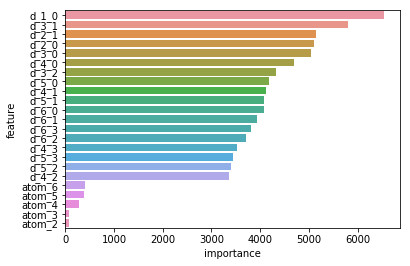

In [25]:
cols = list(df.columns)
cols.remove('scalar_coupling_constant')
cols
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

It's funny, but looks like atom types aren't used a lot in the final decision. Quite a contrary to what a man would do.

## Submission Model

In [20]:
def train_and_predict_for_one_coupling_type(coupling_type, submission, n_atoms, n_folds=5, n_splits=5, random_state=128):
    print(f'*** Training Model for {coupling_type} ***')
    
    X_data, y_data = build_x_y_data(train_csv, coupling_type, n_atoms)
    X_test, _ = build_x_y_data(test_csv, coupling_type, n_atoms)
    y_pred = np.zeros(X_test.shape[0], dtype='float32')

    cv_score = 0
    
    if n_folds > n_splits:
        n_splits = n_folds
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data, y_data)):
        if fold >= n_folds:
            break

        X_train, X_val = X_data[train_index], X_data[val_index]
        y_train, y_val = y_data[train_index], y_data[val_index]

        model = LGBMRegressor(**LGB_PARAMS, n_estimators=1500, n_jobs = -1)
        model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
            verbose=100, early_stopping_rounds=200)

        y_val_pred = model.predict(X_val)
        val_score = np.log(mean_absolute_error(y_val, y_val_pred))
        print(f'{coupling_type} Fold {fold}, logMAE: {val_score}')
        
        cv_score += val_score / n_folds
        y_pred += model.predict(X_test) / n_folds
        
        
    submission.loc[test_csv['type'] == coupling_type, 'scalar_coupling_constant'] = y_pred
    return cv_score

Let's build a separate model for each type of coupling. Dataset is split into 5 pieces and in this kernel we will use only 3 folds for speed up.

Main tuning parameter is the number of atoms. I took good numbers, but accuracy can be improved a bit by tuning them for each type.

In [21]:
model_params = {
    '1JHN': 7,
    '1JHC': 10,
    '2JHH': 9,
    '2JHN': 9,
    '2JHC': 9,
    '3JHH': 9,
    '3JHC': 10,
    '3JHN': 10
}
N_FOLDS = 3
submission = submission_csv.copy()

cv_scores = {}
for coupling_type in model_params.keys():
    cv_score = train_and_predict_for_one_coupling_type(
        coupling_type, submission, n_atoms=model_params[coupling_type], n_folds=N_FOLDS)
    cv_scores[coupling_type] = cv_score

*** Training Model for 1JHN ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3'],
      dtype='object')


NameError: name 'LGBMRegressor' is not defined

Checking cross-validation scores for each type:

In [29]:
pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score': list(cv_scores.values())})

,type,cv_score
0,1JHN,-0.953862
1,1JHC,-0.250532
2,2JHH,-1.716722
3,2JHN,-1.925273
4,2JHC,-1.179941
5,3JHH,-1.735182
6,3JHC,-1.081072
7,3JHN,-2.171047


And cv mean score:

In [30]:
np.mean(list(cv_scores.values()))

-1.3767039168752861

Sanity check for all cells to be filled with predictions:

In [31]:
submission[submission['scalar_coupling_constant'] == 0].shape

(0, 1)

In [32]:
submission.head(10)

,scalar_coupling_constant
id,
4658147,24.126003
4658148,139.170975
4658149,9.896583
4658150,139.170975
4658151,24.126003
4658152,92.646301
4658153,2.797993
4658154,-7.558826
4658155,-9.637208


In [33]:
submission.to_csv(f'{SUBMISSIONS_PATH}/submission.csv')

## Room for improvement

There are many steps, how to improve the score for this kernel:
* Tune LGB hyperparameters - I did nothing for this
* Tune number of atoms for each type
* Try to add other features
* Play with categorical features for atom types (one-hot-encoding, CatBoost?)
* Try other tree libraries

Also, this representation fails badly on `*JHC` coupling types. The main reason for this is that 3rd and 4th atoms are usually located on the same distance and representation starts "jittering" randomly picking one of them. So, two similar configurations will have different representation due to usage of 3/4 of 4/3 distances.

The biggest challenge would be to implement handcrafted KNN with some compiled language(Rust, C++, C).

Would be cool to see this kernel forked and addressed some of the issues with higher LB score.